# Introduction

This notebook aims to explore the droplet generation and cell/nuclei loading processes which take place in a 10X Chromium device.

To that end, we ran the device channels with increasing numbers of nuclei and with a buffer that did not cause lysis. This way, after collecting the droplet emulsion, we were able to simply count optically the number of nuclei in each droplet. Here is how the droplet emulsion looks like for various concentrations:
![FigS1a](http://www.medical-epigenomics.org/papers/datlinger2019/data/FigS1a.png)
For more details on the experimental procedure, please refer to the [scifiRNA-seq preprint](https://biorxiv.org/).

We hoped to gain deeper understanding into the droplet generation, bead and nuclei loading procedures, in order to derive the statistical properties underlying them.

In this notebook we will focus on the nuclei loading procedure and we will use the counts of nuclei per droplet in the resulting emultion to model this distributions and make some predictions about the scalability of Chromium loading and the consequences in terms of nuclei collision (the occurence of more than one uniquely labeled nuclei within a droplet) for the 10X protocol as well as the scifiRNA-seq protocol.

In [2]:
# We'll start by importing the required libraries
import os
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import scipy
from sklearn.linear_model import LinearRegression
import pymc3 as pm

sns.set(context="paper", style="ticks", palette="colorblind", color_codes=True)
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["text.usetex"] = False

savefig = False  # Change to True to save figures as svg files

# The data

We'll read a CSV file with counts of nuclei per droplet for different experiments where the Chromium device was loaded with different concentrations.

In [3]:
# Load observed counts of nuclei per droplet
url = "http://www.medical-epigenomics.org/papers/datlinger2019/data/droplet_counts.csv"
droplet_counts = pd.read_csv(url)

In [4]:
droplet_counts.head()

,loaded_nuclei,cells_per_droplet,count
0,15300,0,509
1,15300,1,89
2,15300,2,8
3,15300,3,2
4,15300,4,0


In [5]:
droplet_counts.tail()

,loaded_nuclei,cells_per_droplet,count
120,1530000,20,2
121,1530000,21,3
122,1530000,22,0
123,1530000,23,0
124,1530000,24,1


Let's calculate relative fractions within experiments for plotting later.

In [6]:
# # split apply combine for fraction normalization
droplet_counts = droplet_counts.join(
    droplet_counts
    .groupby('loaded_nuclei')
    .apply(lambda x: pd.Series((x['count'] / x['count'].sum()).tolist(),
                               index=x.index, name="count (%)"))
    .reset_index(drop=True))
# droplet_counts['norm_count'] += sys.float_info.epsilon

# # split apply combine for % max normalization
droplet_counts = droplet_counts.join(
    droplet_counts
    .groupby('loaded_nuclei')
    .apply(lambda x: pd.Series(((x['count'] / x['count'].max()) * 100).tolist(),
                               index=x.index, name="count (% max)"))
    .reset_index(drop=True))

# # split apply combine for number of droplets counted
droplet_counts = droplet_counts.reset_index().set_index("loaded_nuclei").join(
    droplet_counts.groupby('loaded_nuclei')['count'].sum().rename("droplets_analyzed")
).reset_index().drop("index", axis=1)

The resulting dataframe looks like this:

In [7]:
droplet_counts.head()

,loaded_nuclei,cells_per_droplet,count,count (%),count (% max),droplets_analyzed
0,15300,0,509,0.835796,100.000000,609
1,15300,1,89,0.146141,17.485265,609
2,15300,2,8,0.013136,1.571709,609
3,15300,3,2,0.003284,0.392927,609
4,15300,4,0,0.000000,0.000000,609


In [8]:
droplet_counts.tail()

,loaded_nuclei,cells_per_droplet,count,count (%),count (% max),droplets_analyzed
120,1530000,20,2,0.003185,2.564103,628
121,1530000,21,3,0.004777,3.846154,628
122,1530000,22,0,0.000000,0.000000,628
123,1530000,23,0,0.000000,0.000000,628
124,1530000,24,1,0.001592,1.282051,628


Let's visualize the fraction of empty vs filled droplets per experiment:

In [9]:
# Get droplet empty/fill rates
empty_rate = (
    droplet_counts.set_index("cells_per_droplet")
    .groupby("loaded_nuclei")
    ['count'].apply(lambda x: x.loc[0] / x.sum())
    .rename("empty_rate"))
fill_rate = (
    (1 - empty_rate)
    .rename("fill_rate"))

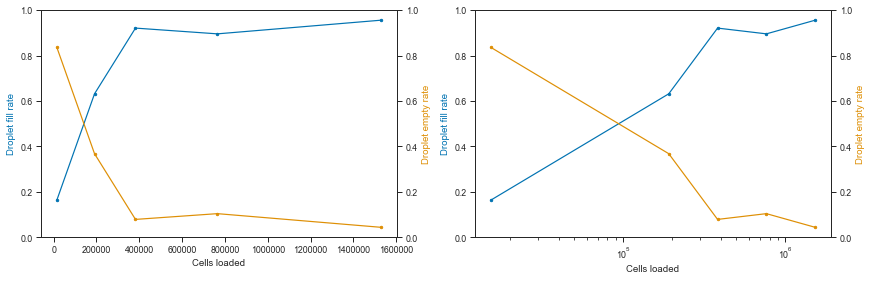

In [10]:
colors = sns.color_palette("colorblind")
fig, axes = plt.subplots(1, 2, figsize=(6.1 * 2, 4))
for axis, scale in zip(axes, ['linear', 'log']):
    axis2 = axis.twinx()
    for i, (ax, var_) in enumerate([(axis, fill_rate), (axis2, empty_rate)]):
        ax.plot(fill_rate.index, var_, ".-", color=colors[i])
        ax.set_xlabel("Cells loaded")
        ax.set_ylabel(f"Droplet {var_.name.replace('_', ' ')}", color=colors[i])
        ax.set_ylim(0, 1)
        ax.set_xscale(scale)
fig.tight_layout()

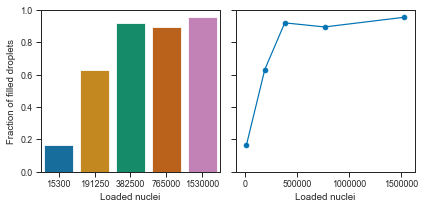

In [11]:
# Fraction of empty vs loading concentration
fig, axis = plt.subplots(1, 2, figsize=(2 * 3, 3), tight_layout=True, sharey=True)
sns.barplot(x=fill_rate.index, y=fill_rate, ax=axis[0])
axis[1].plot(fill_rate.index, fill_rate.values)
axis[1].scatter(fill_rate.index, fill_rate.values)
axis[0].set_ylabel("Fraction of filled droplets")
for ax in axis:
    ax.set_ylim((0, 1))
    ax.set_xlabel("Loaded nuclei")
if savefig:
    fig.savefig(
        "droplet_counts.fill_fraction.barplot.svg",
        dpi=300, bbox_inches="tight")

Okay, we can see that the droplets get filled at an exponential rate.

Let's now plot the distributions of cells per droplet in the various transformations and in linear or log scale.

In [12]:
# # some preparations for plotting
experiments = droplet_counts['loaded_nuclei'].unique()
colors = sns.color_palette("colorblind")

inc = 3
variables = droplet_counts.columns[droplet_counts.columns.str.contains("count")]
nrows = len(variables)
ncols = len(experiments)

In [13]:
# # Plot distributions separately for each experiment
if savefig:
    for sharey, label in [
            (False, "independent_yscale"), ("row", "same_yscale")]:
        fig, axis = plt.subplots(
            nrows * 2, ncols,
            figsize=(nrows * 2 * inc, ncols * inc),
            tight_layout=True, sharex=True, sharey=sharey)
        for i, l in enumerate(variables):
            for j, e in enumerate(experiments):
                dc = droplet_counts.loc[droplet_counts['loaded_nuclei'] == e, :]
                for k, ax in enumerate(axis[[i * 2, i * 2 + 1], j]):
                    sns.barplot(x=dc.index, y=dc[l], ax=ax, color=colors[j])
                if i == 0:
                    axis[i, j].set_title(
                        f"Nuclei loaded: {e}\n"
                        f"Droplets counted: {dc['droplets_analyzed'].unique()[0]}\n"
                        f"Fill fraction: {fill_rate[e]:.4f}")
        for ax in axis[1::2, :].flatten():
            ax.set_yscale("symlog")
            ax.set_ylabel(ax.get_ylabel() + " (log)")
            ax.yaxis.set_major_formatter(ScalarFormatter())
        fig.savefig(
            f"droplet_counts.barplot.{label}.svg",
            dpi=300, bbox_inches="tight")

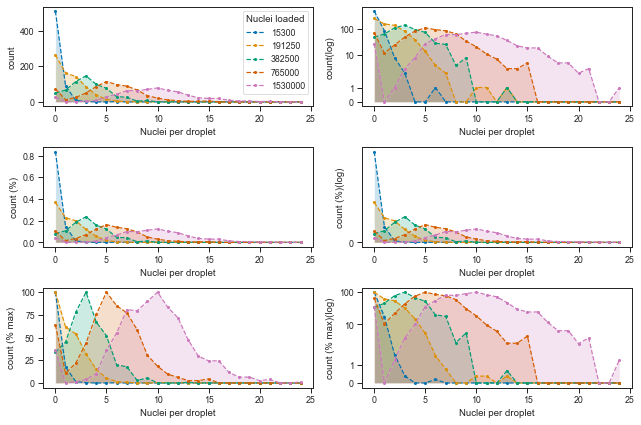

In [14]:
# # Plot experiment distributions jointly across experiments
ncols = 2
x = 'cells_per_droplet'
fig, axis = plt.subplots(
    nrows, ncols,
    figsize=(nrows * inc, ncols * inc),
    tight_layout=True)
for i, l in enumerate(variables):
    for j, e in enumerate(experiments):
        dc = droplet_counts.loc[droplet_counts['loaded_nuclei'] == e]
        for ax in axis[i, :]:
            ax.plot(dc[x], dc[l], marker='o', markersize=2, linestyle="--", label=e)
            ax.fill_between(dc[x], (dc[l]).min(), dc[l], alpha=0.2)
for ax in axis[:, 1]:
    ax.set_yscale("symlog")
    ax.yaxis.set_major_formatter(ScalarFormatter())
for i, l in enumerate(variables):
    axis[i, 0].set_ylabel(l)
    axis[i, 1].set_ylabel(l + "(log)")
    for ax in axis[i, :]:
        ax.set_xlabel("Nuclei per droplet")
axis[0, 0].legend(title="Nuclei loaded")
if savefig:
    fig.savefig(
        "droplet_counts.overlayed_lineplot.svg",
        dpi=300, bbox_inches="tight")

These looks reasonably Poisson-like, but from observing the higher loading concentrations, it is clear that there is more droplets without cells (0 nuclei per droplet) than it would be explained by a Poisson distribution.

Regardless of this zero-component, let's dig a bit further and check whether how the mean/variance relationship of these distributions is.

In order to do that, we'll have to expand the count data in the original observations.

In [15]:
def value_counts_to_observations(dc: pd.Series) -> np.ndarray:
    """
    Generate observations from counts

    Parameters
    ----------
    dc : pd.Series
        Series with index as value and values as counts.
    """
    return np.array([i for i in dc.index for _ in range(dc[i])])

In [16]:
# Check Poisson assumptions
# # Gather observed mean variance per loading concentration, with and without zeros
r_all = dict()
r_nonzero = dict()
for l in droplet_counts['loaded_nuclei'].unique():
    c = value_counts_to_observations(
        droplet_counts.query(f"loaded_nuclei == {l}").set_index("cells_per_droplet")['count'])
    r_all[l] = c.mean(), c.var()
    r_nonzero[l] = c[c > 0].mean(), c[c > 0].var()
r_all = pd.DataFrame(r_all, index=['mean', 'var']).T
r_all.index.name = 'loaded_nuclei'
r_nonzero = pd.DataFrame(r_nonzero, index=['mean', 'var']).T
r_nonzero.index.name = 'loaded_nuclei'

In [17]:
# Let's quickly fit a linear model on the mean/variance relationship
lm_all = LinearRegression() 
lm_all.fit(r_all['mean'].values.reshape((-1, 1)), r_all['var'].values)

lm_nonzero = LinearRegression()
lm_nonzero.fit(r_nonzero['mean'].values.reshape((-1, 1)), r_nonzero['var'].values)
print(lm_all.coef_, lm_all.intercept_)
print(lm_nonzero.coef_, lm_all.intercept_)

[1.60711113] -0.232195442242209
[1.224458] -0.232195442242209


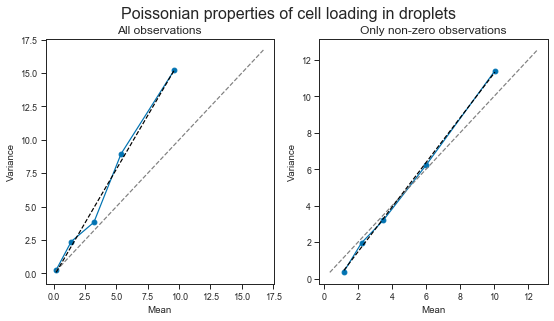

In [18]:
fig, axes = plt.subplots(
    1, 2, figsize=(2 * inc * 1.5, inc * 1.5),
    sharey=False)
fig.suptitle("Poissonian properties of cell loading in droplets", fontsize=16)
axes[0].set_title("All observations", fontsize=12)
axes[1].set_title("Only non-zero observations", fontsize=12)
for ax, r_, lm_ in [(axes[0], r_all, lm_all), (axes[1], r_nonzero, lm_nonzero)]:
    ax.plot(r_['mean'], r_['var'], marker="o")
    vmin = r_.min().min()
    vmin -= vmin * 0.1
    vmax = r_.max().max()
    vmax += vmax * 0.1
    ax.plot(
        (vmin, vmax), (vmin, vmax),
        linestyle="--", color="grey")
    x = np.linspace(r_['mean'].min(), r_['mean'].max())
    ax.plot(
        x, lm_.predict(x.reshape((-1, 1))),
        linestyle="--", color="black")
for ax in axes:
    ax.set_xlabel("Mean")
    ax.set_ylabel("Variance")
if savefig:
    fig.savefig(
        "droplet_counts.poisson_assumptions.mean_vs_var.svg",
        dpi=300, bbox_inches="tight")

We can see that the observed relationship between mean and variance is obviously affected by whether we consider the observations of empty droplets (the later is more of a thought exercise).

However, in both cases, the relationship between mean and variance is larger than 1. This means that the variance increases with higher loading concentrations. We will probably have to deal with higher variance than mean when modeling these data.

Just as a curiosity, it is interesting to see that the variance is the lower range (the one recommended to use by 10X) is lower or equal to the mean. This is however not the sub-Poissonian loading properties of the Chromium (read more here: https://liorpachter.wordpress.com/2019/02/19/introduction-to-single-cell-rna-seq-technologies/ and here https://doi.org/10.6084/m9.figshare.7704659.v1) as that data refers to the *bead loading* process (which achieves sub-poissonian properties due to the deformable beads), and here we are dealing with *cell loading*.


# Modeling the observed distributions

We'll try to model these data in order to understand the latent process underlying its generation and in order to estimate parameters that would allow us to extrapolate the results to any other device loading concentration. This will be useful later when we ask the question:
> "*if I load the device with X nuclei, how many collisions should I expect?*"


## Zero-inflated Poisson distribution
Although from exploring the data a bit we already have reason to suspect these data might not follow exactly a Poisson distribution, for simplicity we will start modeling them with a Zero-Inflated Poisson distribution (ZIP). The zero-inflated component is due to the fact that even in high loading concentrations we observe a considerable ammount of droplets without cells. The ZIP has a $\lambda$ (lambda) parameter to model both mean and variance, but unlike the usual Poisson, also has a $\psi$ (psi) parameter for modeling the zero-inflated component.

The way I interpret $\psi$ is that it is estimating the fraction of droplets with zero cells which did not get filled due to some other factor which does not follow the Poisson process - in other words, the fraction of droplets which did not have the chance to be filled - a *"technical"* reason for being empty.

This could easily be by design, for example in a initial period of burn-in in the device, where cells are not yet going into the microfluic channel that produces droplets.

In [19]:
# Let's assemble all data in a pivot dataframe
droplet_counts_p = droplet_counts.pivot_table(
    index="cells_per_droplet", columns="loaded_nuclei", values="count")
print(droplet_counts_p)

loaded_nuclei      15300    191250   382500   765000   1530000
cells_per_droplet                                             
0                      509      263       49       73       28
1                       89      162       66       12        0
2                        8      142      114       25        1
3                        2       85      146       50        3
4                        0       39       98       86        8
5                        0       14       76      114       28
6                        1        4       29       97       43
7                        0        2       26       88       63
8                        0        0        4       67       62
9                        0        0        8       35       70
10                       0        1        0       21       78
11                       0        1        0       11       65
12                       0        0        0        7       56
13                       0        1        1        3  

In [20]:
# Now we expand these distributions into the actual observed data
counts = [
    np.array([
        i for i in droplet_counts_p.index
        for _ in range(droplet_counts_p.loc[i, j])])
    for j in droplet_counts_p.columns]

In [21]:
# # # # cap all to min(observations) ~= 609
n_exp = len(experiments)
m = min(map(len, counts))
counts = [np.random.choice(x, m) for x in counts]
print(m)

609


Here's our model (easier to read the code bottom to top):
 - the observed count data comes from a Zero-Inflated Poisson distribution, of parameters lambda (theta), psi;
 - the $\lambda$ (lambda) parameter comes from a Exponential distribution ($\lambda$ > 0) for which we impose as prior knowledge the mean number of cells per droplet for within a given experiment;
 - the $\psi$ (psi) parameter comes from a Uniform distribution (0 < $\psi$ < 1) and we don't impose any prior on it;
 - each of these parameters have shape of `n_exp` which is the number of experiments/loading concentrations (i.e. they will be estimated for each loading concentration separately).

In [22]:
# # Fit Zero Inflated Poisson
with pm.Model() as zip_model:
    psi = pm.Uniform('psi', shape=(1, n_exp))
    lam = pm.Exponential('lam', lam=np.mean(counts), shape=(1, n_exp))
    pois = pm.ZeroInflatedPoisson('pois', psi=psi, theta=lam,
                                  observed=pd.DataFrame(counts).T.values)

In [23]:
# Parameters for the MCMC (NUTS) sampler
sampler_params = dict(
    random_seed = 0,  # random seed for reproducibility
    n_init = 200000, # number of iterations of initializer (this is actually the default)
    tune = 5000, # number of tuning iterations (this is probably the most critical)
    draws = 5000, # number of iterations to sample (these will be used for our parameter estimates)
)
TAKE_AFTER = 1000 # number of initial iterations to discard (just as precaution we'll exclude these)

vi_params = dict(
    n = 50000 # iterations
)

In [24]:
# To fit the model, we use MCMC sampling, because it is tractable
with zip_model:
    zip_trace = pm.sample(**sampler_params)[TAKE_AFTER:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam, psi]
Sampling 2 chains, 0 divergences: 100%|██████████| 20000/20000 [00:30<00:00, 657.28draws/s]


In [25]:
# We can now sample from the model posterior
with zip_model:
    zip_ppc_trace = pm.sample_posterior_predictive(
        trace=zip_trace, samples=sampler_params['draws'] * 2, random_seed=sampler_params['random_seed'])

100%|██████████| 10000/10000 [00:08<00:00, 1180.97it/s]


In [26]:
# Just for fun, let's also do Variational Inference too
from pymc3.variational.callbacks import CheckParametersConvergence

with zip_model:
    zip_advi = pm.ADVI()
    zip_tracker = pm.callbacks.Tracker(
        mean=zip_advi.approx.mean.eval,
        std=zip_advi.approx.std.eval
    )
    zip_mean_field = zip_advi.fit(
        n=vi_params['n'], callbacks=[CheckParametersConvergence(), zip_tracker])
zip_vi_trace = zip_mean_field.sample(draws=sampler_params['draws'])

Average Loss = 5,780.7: 100%|██████████| 50000/50000 [00:30<00:00, 1623.27it/s]
Finished [100%]: Average Loss = 5,780.7


To check whether the MCMC model converged, we can observe the value of each parameter in the sequence of samples. Stabilization of the value over the chain means the model converged.

There are two lines per parameter because I used 2 CPUs to sample chains in parallel.

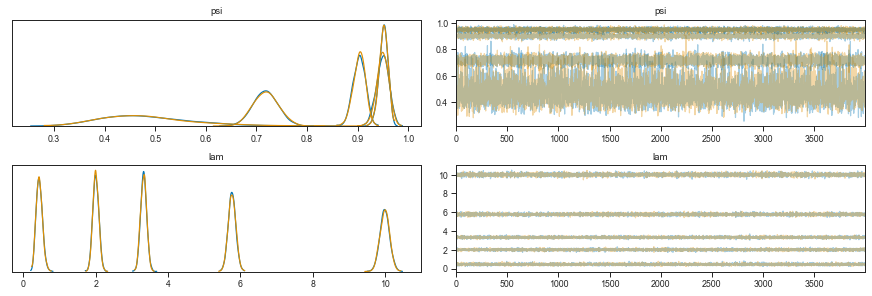

In [27]:
axes = pm.traceplot(zip_trace)
if savefig:
    axes[0, 0].figure.savefig("droplet_counts.ZIP_MCMC_performance.svg",
                              bbox_inches="tight", dpi=300)

We can see that the $\lambda$ parameter increases with device loading concentration. The $\psi$ however has a little back and forth.

In addition, the estimate of $\psi$ for the lowest loading concentration is quite broad. This should come as no surprise as this distribution is in fact mostly zeros - separating the ones expected from a Poisson process from the "technical" ones, is hard.

Let's now have a look at the Variational Inference performance.

The objective is to maximize the evidence lower bound (ELBO). This effectively makes Bayesian inference an optimization problem.

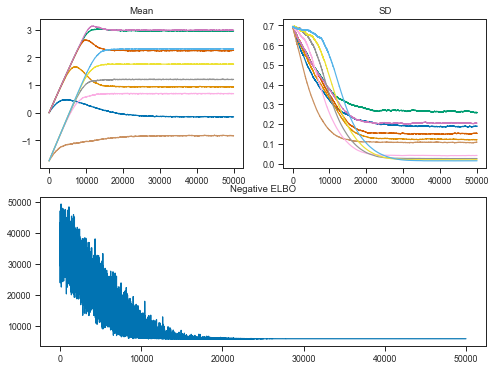

In [28]:
fig = plt.figure(figsize=(8, 6))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(zip_tracker['mean'])
mu_ax.set_title('Mean')
std_ax.plot(zip_tracker['std'])
std_ax.set_title('SD')
hist_ax.plot(zip_advi.hist)
hist_ax.set_title('Negative ELBO')
if savefig:
    fig.savefig("droplet_counts.ZIP_VI_performance.svg", bbox_inches="tight", dpi=300)

In [29]:
zip_vi_trace = zip_mean_field.sample(draws=sampler_params['draws'])

In [30]:
# # Let's gather the model parameters in a dataframe
zip_res = dict()
for param in ['lam', 'psi']:
    for red_func, metric in [(np.mean, '_mean'), (np.std, '_std')]:
        for sampler, s_label in [(zip_trace, '_mcmc'), (zip_vi_trace, '_vi')]:
            zip_res[param + metric + s_label] = red_func(sampler[param], axis=0).flatten()
zip_res = pd.DataFrame(zip_res, index=pd.Series(experiments, name="loaded_nuclei"))
if savefig:
    zip_res.to_csv("droplet_counts.joint_model.ZIP_params.csv")
print(zip_res)

               lam_mean_mcmc  lam_mean_vi  lam_std_mcmc  lam_std_vi  \
loaded_nuclei                                                         
15300               0.437405     0.439764      0.085570    0.048505   
191250              1.999454     1.988304      0.081287    0.080989   
382500              3.321722     3.326178      0.082102    0.085014   
765000              5.766861     5.757179      0.103082    0.111554   
1530000             9.992216    10.021525      0.130423    0.140611   

               psi_mean_mcmc  psi_mean_vi  psi_std_mcmc  psi_std_vi  
loaded_nuclei                                                        
15300               0.482498     0.463390      0.091216    0.046608  
191250              0.717861     0.717384      0.024540    0.024842  
382500              0.949200     0.948621      0.012091    0.012536  
765000              0.902959     0.903910      0.012053    0.013317  
1530000             0.950930     0.950629      0.008769    0.009652  


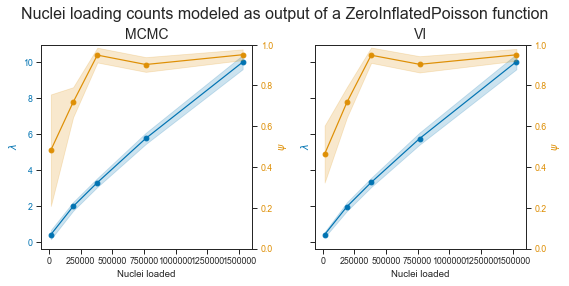

In [31]:
# # # Plot estimated lamba
fig, axis = plt.subplots(1, 2, figsize=(2 * 4, 4), sharey=True, sharex=True)
fig.suptitle("Nuclei loading counts modeled as output of a ZeroInflatedPoisson function", fontsize=16)
axis2 = [ax.twinx() for ax in axis]
# axis[0].get_shared_y_axes().join(axis[1])
for i, method in enumerate(["mcmc", "vi"]):
    axis[i].set_title("\n" + method.upper(), fontsize=14)
    axis[i].plot(
        zip_res.index,
        zip_res[f'lam_mean_{method}'],
        color=colors[0], marker='o')
    axis[i].fill_between(
        zip_res.index,
        zip_res[f'lam_mean_{method}'] - zip_res[f'lam_std_{method}'] * 3,
        zip_res[f'lam_mean_{method}'] + zip_res[f'lam_std_{method}'] * 3,
        color=colors[0], alpha=0.2)
    axis[i].tick_params(axis='y', labelcolor=colors[0])

    axis2[i].plot(
        zip_res.index,
        zip_res[f'psi_mean_{method}'],
        color=colors[1], marker='o')
    axis2[i].fill_between(
        zip_res.index,
        zip_res[f'psi_mean_{method}'] - zip_res[f'psi_std_{method}'] * 3,
        zip_res[f'psi_mean_{method}'] + zip_res[f'psi_std_{method}'] * 3,
        color=colors[1], alpha=0.2)
    axis2[i].tick_params(axis='y', labelcolor=colors[1])
    axis[i].set_xlabel("Nuclei loaded")
    axis[i].set_ylabel(r"$\lambda$", color=colors[0])
    axis2[i].set_ylabel(r"$\psi$", color=colors[1])
    axis2[i].set_ylim(0, 1)
fig.tight_layout()
if savefig:
    fig.savefig(
        "droplet_counts.ZIP_params.svg",
        dpi=300, bbox_inches="tight", tight_layout=True)

Alright!

The plot on the left shows the MCMC estimates for the two parameters, and the right one the one from Variational Inference. They are really similar. The $\lambda$ parameter looks pretty (but not quite) linear within the range of observed values. This is no suprise as the observed count distributions clearly show a shift towards more filled droplets and droplets with more cells.

As MCMC given enough sampling is guaranteed to find an optimal solution (and has other advantages such as a generative process), I will use mostly those estimates. They seem to support the observed data well. We can also see that we have less confidence for the estimation of $\psi$ in the lower end of droplet concentration, as expected.

So overal we probably have good estimates of the parameters of a ZIP model.

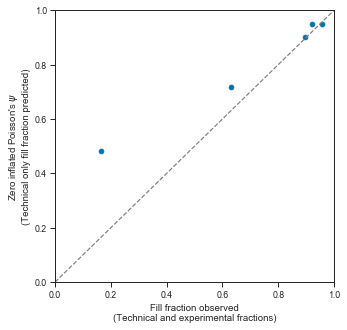

In [32]:
# # # Plot estimated zero inflated component (PSI) vs observed zero fraction
fill_rate2 = fill_rate.to_frame().join(zip_res['psi_mean_mcmc'])

fig, axis = plt.subplots(figsize=(5, 5))
axis.scatter(fill_rate2['fill_rate'], fill_rate2['psi_mean_mcmc'])
axis.plot((0, 1), (0, 1), linestyle="--", color="grey")
axis.set_xlim((0, 1))
axis.set_ylim((0, 1))
axis.set_xlabel("Fill fraction observed\n(Technical and experimental fractions)")
axis.set_ylabel("Zero inflated Poisson's $\psi$ \n(Technical only fill fraction predicted)")
if savefig:
    fig.savefig(
        "droplet_counts.fill_fraction.measured_vs_ZIP_psi_param.svg",
        dpi=300, bbox_inches="tight")

This shows that in high loading concentrations, the empty droplets are almost fully explained by a technical component then by the "normal" underlying Poisson process.

### Using this model to project doublet rates in scifiRNA-seq data

Now let's project doublet rates as a function of loading rate, given a fixed number of barcodes in round 1.

We simply have to divide the number of input cells per number of barcodes since round 1 barcoding effectively reduces the number of collisions we care about by the same order.

Then, we simply need to lookup the respective ZIP parameter for that input and get what part of the cell per droplet distribution is bigger than 1.

In theory the second step could be done simply by getting the `1 - Poisson($\lambda$).CDF(2)`, but scipy does not implement a CDF method for a Zero Inflated Poisson distribution and PYMC3 also does not have a logcdf/logpmf yet :(

We will try to sample from the distribution (using scipy's `rvs` method) and set a number of those draws to 0 conditioned on a draws from a bernouli distribution of parameter `PSI` to simulate the zero inflated component of the ZIP.

In [33]:
# # Okay, so we interpolate over loading concentrations and get the values of each parameter

zip_lambda_f = scipy.interpolate.interp1d(
    zip_res.index, zip_res['lam_mean_mcmc'],
    kind='quadratic', fill_value="extrapolate")
zip_psi_f = scipy.interpolate.interp1d(
    zip_res.index, zip_res['psi_mean_mcmc'],
    kind='quadratic', fill_value="extrapolate")

In [34]:
# # Now we use those functions to predict across a range
x = np.linspace(1000, zip_res.index.max())
zip_lambda_y = zip_lambda_f(x)
zip_psi_y = zip_psi_f(x)

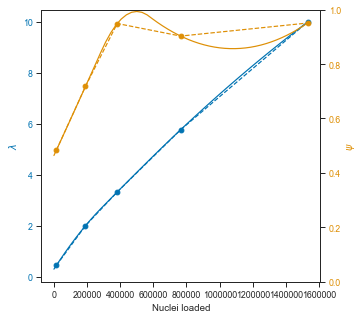

In [35]:
# # # Plot estimated lamba
fig, axis = plt.subplots(figsize=(5, 5))
axis.plot(
    zip_res.index, zip_res['lam_mean_mcmc'],
    color=colors[0], marker="o", linestyle="--")
axis.plot(x, zip_lambda_y, color=colors[0], linestyle="-")
axis.tick_params(axis='y', labelcolor=colors[0])
axis2 = axis.twinx()
axis2.plot(
    zip_res.index, zip_res['psi_mean_mcmc'],
    color=colors[1], marker="o", linestyle="--")
axis2.plot(x, zip_psi_y, color=colors[1], linestyle="-")
axis2.tick_params(axis='y', labelcolor=colors[1])
axis.set_xlabel("Nuclei loaded")
axis.set_ylabel(r"$\lambda$", color=colors[0])
axis2.set_ylabel(r"$\psi$", color=colors[1])
axis2.set_ylim(0, 1)
if savefig:
    fig.savefig(
        "droplet_counts.ZIP_params.interpolated.svg",
        dpi=300, bbox_inches="tight")

So the interpolation over $\psi$ does not look great and is obviously overfitting.

**NOTE**: I will likely replace this with simple linear regression.

In [36]:
# # Now we sample across the X
# x = np.linspace(1000, zip_res.index.max(), 10)
x = np.logspace(3, 6.5, num=10, base=10)
n = int(1e5)
f = dict()
barcode_combos = [1, 96, 96 * 4, 96 * 16]
for barcodes in barcode_combos:
    for input_nuclei in x:
        psi = zip_psi_f([input_nuclei / barcodes])[0]
        # bounding PSI to [0, 1] since the extrapolation is unbounded
        psi = min(psi, 1)  
        psi = max(psi, 0)
        lamb = zip_lambda_f([input_nuclei / barcodes])[0]

        # s = scipy.stats.bernoulli(psi).rvs(n) * scipy.stats.poisson(lamb).rvs(n)
        s = pm.distributions.ZeroInflatedPoisson.dist(psi=psi, theta=lamb).random(size=n)

        # Now we simply count fraction of doublets (droplets with more than one nuclei)
        f[(barcodes, input_nuclei)] = [lamb, psi, (s > 1).sum() / n]
f = pd.DataFrame(f, index=["lambda", "psi", "doublet_rate"]).T
f.index.names = ['barcodes', 'loaded_nuclei']
print(f)

                           lambda       psi  doublet_rate
barcodes loaded_nuclei                                   
1        1.000000e+03    0.293869  0.463584       0.01689
         2.448437e+03    0.308521  0.465498       0.01798
         5.994843e+03    0.344288  0.470187       0.02115
         1.467799e+04    0.431214  0.481675       0.03351
         3.593814e+04    0.640165  0.509853       0.06886
         8.799225e+04    1.128507  0.579146       0.17910
         2.154435e+05    2.184723  0.750606       0.48059
         5.274997e+05    4.267001  0.991129       0.91848
         1.291550e+06    8.774839  0.877488       0.87683
         3.162278e+06   15.901714  1.000000       1.00000
96       1.000000e+03    0.283844  0.462276       0.01548
         2.448437e+03    0.283997  0.462296       0.01524
         5.994843e+03    0.284371  0.462345       0.01469
         1.467799e+04    0.285288  0.462464       0.01520
         3.593814e+04    0.287532  0.462757       0.01688
         8.799

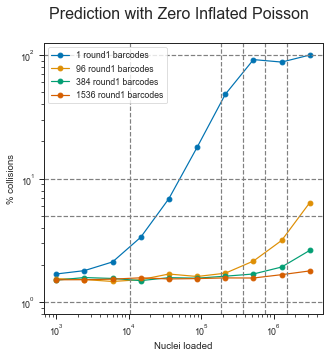

In [37]:
fig, axis = plt.subplots(1, 1, figsize=(1 * 5, 5))
fig.suptitle("Prediction with Zero Inflated Poisson", fontsize=16)
for barcodes in barcode_combos:
    axis.plot(
        f.loc[barcodes].index, f.loc[barcodes, 'doublet_rate'] * 100,
        linestyle="-", marker="o", label=f"{barcodes} round1 barcodes")
axis.set_xscale("log")
axis.set_yscale("log")
axis.set_xlabel("Nuclei loaded")
axis.set_ylabel("% collisions")
axis.legend()
for x_ in [100, 10, 5, 1]:
    axis.axhline(x_, color="grey", linestyle="--")
for y_ in [10500, 191000, 383000, 765000, 1530000]:
    axis.axvline(y_, color="grey", linestyle="--")
if savefig:
    fig.savefig(
        "droplet_counts.ZIP_params.prediction_of_doublet_rate.svg",
        dpi=300, bbox_inches="tight")

## Zero-inflated Negative binomial distribution

We saw previously that the Poisson distribution (or the Zero-inflated Poisson) might not be the best for these data, since the relationship between variance and mean is not 1.

A related distribution that models mean and variance with with two parameters is the Negative Binomial distribution. Just as we used the zero-inflated component on the ZIP, we can also have a Zero-Inflated Negative Binomial (ZINB) distribution. The ZINB has a $\mu$ (mu) parameter to model the mean, a $\alpha$ parameter for the dispersion, and a $\psi$ (psi) parameter for the zero-inflated component.

My interpretation of $\psi$ is the same as in ZIP - the main difference between the two distributions is in how variation is handled.

Here's this model (again from bottom to top):
 - the observed count data comes from a Zero-Inflated Negative Binomial distribution, of parameters mu, alpha and psi;
 - the $\mu$ (mu) parameter, just like in the ZIP distribution, comes from a Exponential distribution ($\lambda$ > 0) for which we impose as prior knowledge the mean number of cells per droplet for within a given experiment;
 - the $\alpha$ (alpha) parameter, is Gamma distributed, which is in it's turn parametrized with $\alpha$ (shape; $\alpha$ > 0) and $\beta$ (scale/rate; $\beta$ > 0). For the priors, here I'm a bit at loss so for $\alpha$ I use the the standard deviation of the observed counts and 5 for $\beta$;
 - the $\psi$ (psi) parameter comes from a Uniform distribution (0 < $\psi$ < 1) and we don't impose any prior on it;
 - each of these parameters have shape of `n_exp` which is the number of experiments/loading concentrations (i.e. they will be estimated for each loading concentration separately).

In [38]:
with pm.Model() as zinb_model:
    psi = pm.Uniform('psi', shape=(1, n_exp))
    mu = pm.Exponential('mu', lam=np.mean(counts), shape=(1, n_exp))
    alpha = pm.Gamma('alpha', alpha=np.std(counts), beta=5, shape=(1, n_exp))
    nb = pm.ZeroInflatedNegativeBinomial('nb', psi=psi, mu=mu, alpha=alpha,
                                         observed=pd.DataFrame(counts).T.values)

In [39]:
# To fit the model, let's use MCMC to sample, because it is tractable
with zinb_model:
    zinb_trace = pm.sample(**sampler_params)[TAKE_AFTER:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, mu, psi]
Sampling 2 chains, 52 divergences: 100%|██████████| 20000/20000 [01:45<00:00, 188.68draws/s]
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [40]:
with zinb_model:
    zinb_ppc_trace = pm.sample_posterior_predictive(
        zinb_trace, sampler_params['draws'] * 2, random_seed=sampler_params['random_seed'])

100%|██████████| 10000/10000 [00:11<00:00, 850.79it/s]


In [41]:
# Just for fun, let's also do Variational Inference too
from pymc3.variational.callbacks import CheckParametersConvergence

with zinb_model:
    zinb_advi = pm.ADVI()
    zinb_tracker = pm.callbacks.Tracker(
        mean=zinb_advi.approx.mean.eval,
        std=zinb_advi.approx.std.eval
    )
    zinb_mean_field = zinb_advi.fit(
        n=vi_params['n'], callbacks=[CheckParametersConvergence(), zinb_tracker])
zinb_vi_trace = zinb_mean_field.sample(draws=sampler_params['draws'])

Average Loss = 5,924.6: 100%|██████████| 50000/50000 [00:53<00:00, 935.31it/s] 
Finished [100%]: Average Loss = 5,924.6


Let's inspect the model fits.

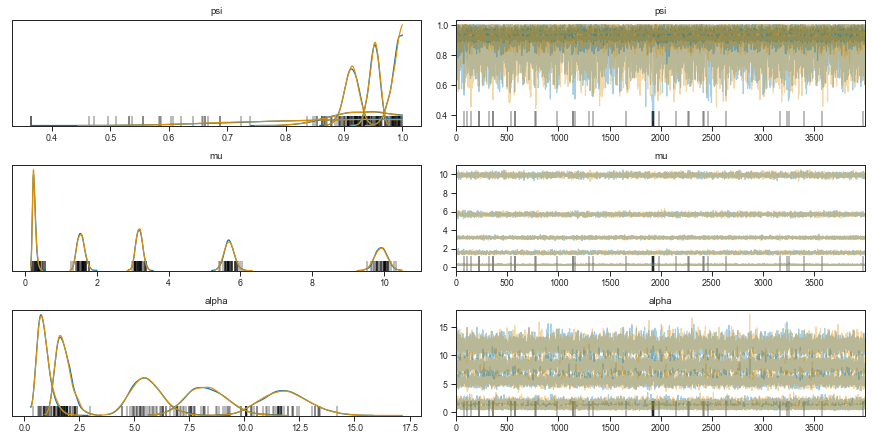

In [42]:
axes = pm.traceplot(zinb_trace)
if savefig:
    axes[0, 0].figure.savefig("droplet_counts.joint_model.ZINB_sampling.svg",
                              bbox_inches="tight", dpi=300)

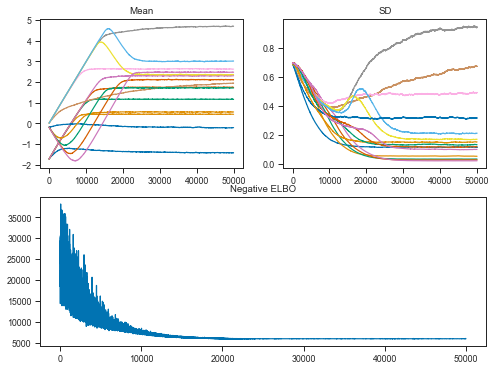

In [43]:
fig = plt.figure(figsize=(8, 6))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(zinb_tracker['mean'])
mu_ax.set_title('Mean')
std_ax.plot(zinb_tracker['std'])
std_ax.set_title('SD')
hist_ax.plot(zinb_advi.hist)
hist_ax.set_title('Negative ELBO');
if savefig:
    fig.savefig("droplet_counts.ZINB_VI_performance.svg", bbox_inches="tight", dpi=300)

Okay, it didn't converge fully but it's probably good enough.

In [44]:
# Let's collect the model posteriors
zinb_res = dict()
for param in ['mu', 'alpha', 'psi']:
    for red_func, metric in [(np.mean, '_mean'), (np.std, '_std')]:
        for sampler, s_label in [(zinb_trace, '_mcmc'), (zinb_vi_trace, '_vi')]:
            zinb_res[param + metric + s_label] = red_func(sampler[param], axis=0).flatten()
zinb_res = pd.DataFrame(zinb_res, index=pd.Series(experiments, name="loaded_nuclei"))
if savefig:
    zinb_res.to_csv("droplet_counts.joint_model.ZINB_params.csv")
print(zinb_res)

               mu_mean_mcmc  mu_mean_vi  mu_std_mcmc  mu_std_vi  \
loaded_nuclei                                                     
15300              0.252255    0.240411     0.047009   0.027336   
191250             1.552145    1.539827     0.105615   0.077658   
382500             3.181334    3.171134     0.093812   0.097421   
765000             5.687228    5.676871     0.135440   0.144371   
1530000            9.929232    9.973743     0.173669   0.190277   

               alpha_mean_mcmc  alpha_mean_vi  alpha_std_mcmc  alpha_std_vi  \
loaded_nuclei                                                                 
15300                 0.885246       0.846011        0.299376      0.268840   
191250                1.785842       1.743211        0.354235      0.264529   
382500                5.559653       5.543956        0.709964      0.734716   
765000                8.286683       8.303245        0.914013      0.970718   
1530000              11.836782      11.840635        1.0

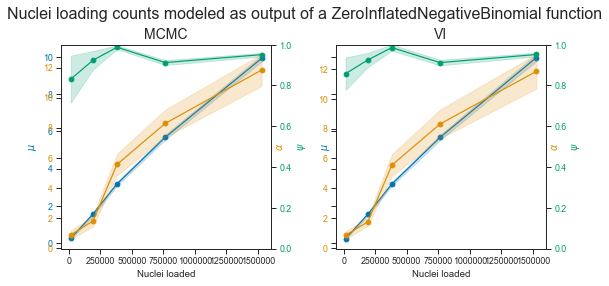

In [45]:
# # # Plot posterior 
fig, axis = plt.subplots(1, 2, figsize=(2 * 4, 4), sharey=True, sharex=True)
fig.suptitle(
    "Nuclei loading counts modeled as output of a ZeroInflatedNegativeBinomial function",
    fontsize=16)
axis2 = [ax.twinx() for ax in axis]
axis3 = [ax.twinx() for ax in axis2]
# axis[0].get_shared_y_axes().join(axis[1])
for i, method in enumerate(["mcmc", "vi"]):
    axis[i].set_title("\n" + method.upper(), fontsize=14)
    axis[i].plot(
        zinb_res.index,
        zinb_res[f'mu_mean_{method}'],
        color=colors[0], marker='o')
    axis[i].fill_between(
        zinb_res.index,
        zinb_res[f'mu_mean_{method}'] - zinb_res[f'mu_std_{method}'],
        zinb_res[f'mu_mean_{method}'] + zinb_res[f'mu_std_{method}'],
        color=colors[0], alpha=0.2)
    axis[i].tick_params(axis='y', labelcolor=colors[0])

    axis2[i].plot(
        zinb_res.index,
        zinb_res[f'alpha_mean_{method}'],
        color=colors[1], marker='o')
    axis2[i].fill_between(
        zinb_res.index,
        zinb_res[f'alpha_mean_{method}'] - zinb_res[f'alpha_std_{method}'],
        zinb_res[f'alpha_mean_{method}'] + zinb_res[f'alpha_std_{method}'],
        color=colors[1], alpha=0.2)
    axis2[i].tick_params(axis='y', labelcolor=colors[1])

    axis3[i].plot(
        zinb_res.index,
        zinb_res[f'psi_mean_{method}'],
        color=colors[2], marker='o')
    axis3[i].fill_between(
        zinb_res.index,
        zinb_res[f'psi_mean_{method}'] - zinb_res[f'psi_std_{method}'],
        zinb_res[f'psi_mean_{method}'] + zinb_res[f'psi_std_{method}'],
        color=colors[2], alpha=0.2)
    axis3[i].tick_params(axis='y', labelcolor=colors[2])

    axis[i].set_xlabel("Nuclei loaded")
    axis[i].set_ylabel(r"$\mu$", color=colors[0])
    axis2[i].set_ylabel(r"$\alpha$", color=colors[1])
    axis3[i].set_ylabel(r"$\psi$", color=colors[2])

    axis3[i].set_ylim(0, 1)
fig.tight_layout()
if savefig:
    fig.savefig(
        "droplet_counts.ZINB_params.svg",
        dpi=300, bbox_inches="tight", tight_layout=True)

Okay!

This time VI and MCMC still roughly agree. The estimate of $\mu$ continues to increase, similar to the $\lambda$ parameter in the ZIP model.

The dispersion parameter $\alpha$ is however much harder to estimate. It is however often both larger than $\mu$ and increasing with nuclei loading which are the properties we expect from it.

I will again use MCMC over VI for the ZINB model posterior parameter estimates.

[1.16834092] 0.8567637198540723


Text(0, 0.5, '$\\alpha$')

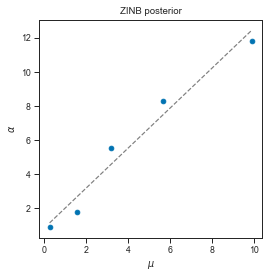

In [46]:
# Analogously, we can again see the mean/variance relashionship on the posterior
lm_zinb = LinearRegression()
lm_zinb.fit(
    zinb_res['mu_mean_mcmc'].values.reshape((-1, 1)),
    zinb_res['alpha_mean_mcmc'].values)
print(lm_zinb.coef_, lm_zinb.intercept_)

fig, axis = plt.subplots(1, 1, figsize=(4, 4))
axis.scatter(zinb_res['mu_mean_mcmc'], zinb_res['alpha_mean_mcmc'])
x = np.linspace(zinb_res['mu_mean_mcmc'].min(), zinb_res['mu_mean_mcmc'].max())
axis.plot(x, lm_zinb.predict(x.reshape((-1, 1))), linestyle='--', color="grey")
axis.set_title("ZINB posterior")
axis.set_xlabel(r"$\mu$")
axis.set_ylabel(r"$\alpha$")

In [47]:
# # So first we interpolate over a range of loading concentrations and get the parameter values
# interpolation_type = "slinear"
interpolation_type = "quadratic"
zinb_mu_f = scipy.interpolate.interp1d(
    zinb_res.index, zinb_res['mu_mean_mcmc'],
    kind=interpolation_type, fill_value="extrapolate")
zinb_alpha_f = scipy.interpolate.interp1d(
    zinb_res.index, zinb_res['alpha_mean_mcmc'],
    kind=interpolation_type, fill_value="extrapolate")
zinb_psi_f = scipy.interpolate.interp1d(
    zinb_res.index, zinb_res['psi_mean_mcmc'],
    kind=interpolation_type, fill_value="extrapolate")

In [48]:
# Now generate across range
x = np.linspace(1000, zinb_res.index.max())
zinb_mu_y = zinb_mu_f(x)
zinb_alpha_y = zinb_alpha_f(x)
zinb_psi_y = zinb_psi_f(x)

In [49]:
# # With linear regression
# zinb_mu_f = LinearRegression()
# zinb_mu_f.fit(zinb_res.index.values.reshape((-1, 1)), zinb_res['mu_mean_mcmc'].values)
# zinb_alpha_f = LinearRegression()
# zinb_alpha_f.fit(zinb_res.index.values.reshape((-1, 1)), zinb_res['alpha_mean_mcmc'].values)
# zinb_psi_f = LinearRegression()
# zinb_psi_f.fit(zinb_res.index.values.reshape((-1, 1)), zinb_res['psi_mean_mcmc'].values)
# x = np.linspace(1000, zinb_res.index.max()).reshape((-1, 1))
# zinb_mu_y = zinb_mu_f.predict(x)
# zinb_alpha_y = zinb_alpha_f.predict(x)
# zinb_psi_y = zinb_psi_f.predict(x)

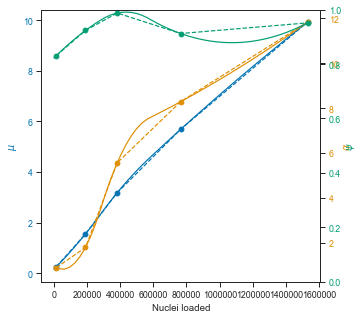

In [50]:
# # # Plot estimated lamba
fig, axis = plt.subplots(figsize=(5, 5))
axis.plot(
    zinb_res.index, zinb_res['mu_mean_mcmc'],
    color=colors[0], marker="o", linestyle="--")
axis.plot(x, zinb_mu_y, color=colors[0], linestyle="-")
axis.tick_params(axis='y', labelcolor=colors[0])
axis2 = axis.twinx()
axis2.plot(
    zinb_res.index, zinb_res['alpha_mean_mcmc'],
    color=colors[1], marker="o", linestyle="--")
axis2.plot(x, zinb_alpha_y, color=colors[1], linestyle="-")
axis2.tick_params(axis='y', labelcolor=colors[1])
axis3 = axis.twinx()
axis3.plot(
    zinb_res.index, zinb_res['psi_mean_mcmc'],
    color=colors[2], marker="o", linestyle="--")
axis3.plot(x, zinb_psi_y, color=colors[2], linestyle="-")
axis3.tick_params(axis='y', labelcolor=colors[2])

axis.set_xlabel("Nuclei loaded")
axis.set_ylabel(r"$\mu$", color=colors[0])
axis2.set_ylabel(r"$\alpha$", color=colors[1])
axis3.set_ylabel(r"$\psi$", color=colors[2])
# axis2.set_ylim(0, 1)
axis3.set_ylim(0, 1)
if savefig:
    fig.savefig(
        "droplet_counts.ZIP_params.interpolated.svg",
        dpi=300, bbox_inches="tight")

In [51]:
import sys
# # Now we sample across the X
# x = np.linspace(zinb_res.index.min(), zinb_res.index.max(), 10)
# x = np.linspace(zinb_res.index.min(), zinb_res.index.max() * 4, 10)
x = np.logspace(3, 6.5, num=10, base=10)
n = int(1e5)
f = dict()
barcode_combos = [1, 96, 96 * 4, 96 * 16]
for barcodes in barcode_combos:
    for input_nuclei in x:
        psi = zinb_psi_f([input_nuclei / barcodes])[0]
        # bounding PSI to [0, 1] since the extrapolation is unbounded
        psi = min(psi, 1 - sys.float_info.epsilon)
        psi = max(psi, 0 + sys.float_info.epsilon)
        # alpha = zinb_alpha_f([input_nuclei / barcodes])[0]
        # ALPHA should also be bound to [0, +inf] since the extrapolation is unbounded.
        # However, it's a bit more tricky then to set it to and arbitrary low value
        # (e.g. sys.float_info.epsilon). Instead I regularize it with a ReLU function.
        alpha = np.log(1 + np.e ** zinb_alpha_f([input_nuclei / barcodes])[0])
        mu = zinb_mu_f([input_nuclei / barcodes])[0]
        try:
            s = (
                pm.distributions
                .ZeroInflatedNegativeBinomial
                .dist(psi=psi, mu=mu, alpha=alpha).random(size=n))
        except ValueError:
            print(f"Failed at {barcodes}, {int(input_nuclei)} "
                  f"with parameters: {mu:.2f}, {alpha:.2f}, {psi:.2f}")
            continue
        if s.sum() == 0:
            continue
        # Now we simply count fraction of doublets
        f[(barcodes, input_nuclei)] = [mu, alpha, psi, (s > 1).sum() / n]
f = pd.DataFrame(f, index=["mu", "alpha", "psi", "doublet_rate"]).T
f.index.names = ['barcodes', 'loaded_nuclei']
print(f)

                               mu      alpha       psi  doublet_rate
barcodes loaded_nuclei                                              
1        1.000000e+03    0.158251   1.277566  0.822348       0.01443
         2.448437e+03    0.167693   1.272095  0.823231       0.01562
         5.994843e+03    0.190887   1.259394  0.825384       0.01966
         1.467799e+04    0.248130   1.232400  0.830612       0.03082
         3.593814e+04    0.391010   1.190056  0.843153       0.06518
         8.799225e+04    0.757174   1.223013  0.872304       0.16042
         2.154435e+05    1.751603   2.266193  0.934359       0.42690
         5.274997e+05    4.239832   7.305513  0.980458       0.85256
         1.291550e+06    8.670790  10.626222  0.895200       0.88619
         3.162278e+06   16.992353  22.653441  1.000000       0.99999
96       1.000000e+03    0.151810   1.281400  0.821745       0.01301
         2.448437e+03    0.151908   1.281341  0.821754       0.01298
         5.994843e+03    0.152149 

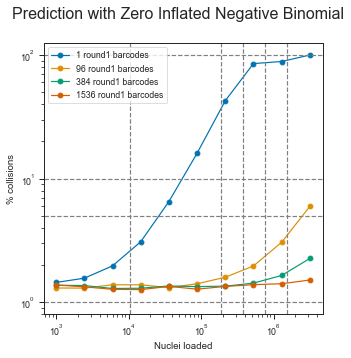

In [52]:
fig, axis = plt.subplots(1, 1, figsize=(1 * 5, 5))
fig.suptitle("Prediction with Zero Inflated Negative Binomial", fontsize=16)
for barcodes in f.index.levels[0]:
    axis.plot(
        f.loc[barcodes].index, f.loc[barcodes, 'doublet_rate'] * 100,
        linestyle="-", marker="o", label=f"{barcodes} round1 barcodes")
axis.set_xscale("log")
axis.set_yscale("log")
axis.set_xlabel("Nuclei loaded")
axis.set_ylabel("% collisions")
axis.legend()
for x_ in [100, 10, 5, 1]:
    axis.axhline(x_, color="grey", linestyle="--")
for y_ in [10500, 191000, 383000, 765000, 1530000]:
    axis.axvline(y_, color="grey", linestyle="--")
if savefig:
    fig.savefig(
        "droplet_counts.ZINB_params.prediction_of_doublet_rate.svg",
        dpi=300, bbox_inches="tight")

The ZINB model also seems to show that the $\mu$ parameter is more or less linear in the observed range (this is important for scalability) and that it would be theoretically possible to load up to ~1 million pre-labeled nuclei with the scifi method into the Chromium device.

# Model comparison
It seems the ZINB model largely agrees with the ZIP. Can we quantify which one "performs better" ideally taking into account the differences between model complexity?

## WAIC

There are various ways. One option is to use for example the Watanabe–Akaike information criterion (WAIC) and associated metrics. For more information on the practical interpretation of these metrics see for example the PyMC3 tutorial pages on the subejct here: https://docs.pymc.io/notebooks/model_comparison.html#Widely-applicable-Information-Criterion-(WAIC)

In [53]:
zip_waic = pm.waic(zip_trace, zip_model)
zinb_waic = pm.waic(zinb_trace, zinb_model)

print(f"ZIP model WAIC: {zip_waic.waic:.3f}")
print(f"ZINB model WAIC: {zinb_waic.waic:.3f}")

/home/afr/.local/lib/python3.7/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


ZIP model WAIC: 11379.860
ZINB model WAIC: 11483.723


In [54]:
if pm.__version__ == "3.8":
    df_comp_WAIC = pm.compare({"ZIP": zip_trace, "ZINB": zinb_trace}, ic="WAIC")
elif pm.__version__.split('.')[1] < '8':
    df_comp_WAIC = pm.compare({zip_model: zip_trace, zinb_model: zinb_trace}, ic="WAIC")
    df_comp_WAIC.index = (
        df_comp_WAIC.index
       .to_series()
       .replace(0, 'ZIP')
       .replace(1, 'ZINB'))
else:
    ValueError("Please install PYMC3 version 3.6 or 3.8.")

if savefig:
    df_comp_WAIC.to_csv("droplet_counts.WAIC_comparison.csv")
print(df_comp_WAIC)

     rank     waic   p_waic   d_waic      weight       se      dse warning  \
ZIP     0  11379.9  11.8109        0    0.997478  131.318        0    True   
ZINB    1  11483.7   9.6716  103.863  0.00252247  116.791  35.0087    True   

     waic_scale  
ZIP    deviance  
ZINB   deviance  


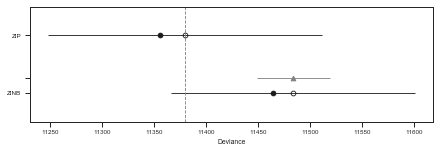

In [55]:
pm.compareplot(df_comp_WAIC)

## Leave one out cross-validation


In [56]:
zip_loo = pm.loo(zip_trace, zip_model)
zinb_loo = pm.loo(zinb_trace, zinb_model)

print(f"ZIP model LOO: {zip_loo.loo:.3f}")
print(f"ZINB model LOO: {zinb_loo.loo:.3f}")

ZIP model LOO: 11379.856
ZINB model LOO: 11483.727


In [57]:
if pm.__version__ == "3.8":
    df_comp_LOO = pm.compare({"ZIP": zip_trace, "ZINB": zinb_trace}, ic="LOO")
elif pm.__version__.split('.')[1] < '8':
    df_comp_LOO = pm.compare({zip_model: zip_trace, zinb_model: zinb_trace}, ic="LOO")
    df_comp_LOO.index = (
        df_comp_LOO.index
       .to_series()
       .replace(0, 'ZIP')
       .replace(1, 'ZINB'))
else:
    ValueError("Please install PYMC3 version 3.6 or 3.8.")
if savefig:
    df_comp_LOO.to_csv("droplet_counts.LOO_comparison.csv")
print(df_comp_LOO)

     rank      loo    p_loo    d_loo      weight       se     dse warning  \
ZIP     0  11379.9  11.8087        0    0.996112  126.292       0   False   
ZINB    1  11483.7  9.67338  103.871  0.00388844  112.788  35.007   False   

     loo_scale  
ZIP   deviance  
ZINB  deviance  


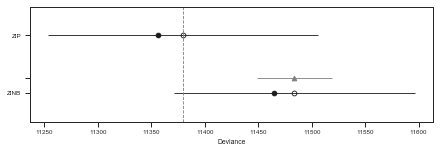

In [58]:
pm.compareplot(df_comp_LOO)

The tables and plots the above show that the ZIP model is substancially b a better choice than the ZINB regarding a balance between model complexity (overfitting) and model performance (underfitting).

The outcome of this model helps to demonstrate how the Chromium device can be loaded beyond the recommended by 10X as long as one can pre-label the nuclei with enough complexity.

# Conclusion

Both models show that the mean number of nuclei per droplet ($\lambda$ or $\mu$ parameters in ZIP or ZINB models respectively) increases mostly linearly within the observed range. This means that there is great room for "overloading" the Chromium device if collision events are handled.

That's exactly what the *scifi* concept introduces: by labeling all molecules of the transcriptome of each cell, one is able to reduce the number of colisions linearly by the number of unique round1 combinations. Modeling the nuclei loading procedure on the Chromium device shows that it is theoretically possible to load up to ~1 million pre-labeled nuclei with the scifi method into the Chromium device with an acceptable collision rate.


# Appendix

Some technical considerations:
- On the zero inflation:
    - Please don't confuse what I model here as a zero inflation component as the zero inflation in transcript detection in single cell RNA-seq. Various people in the field have recently argued that there is no zero inflation at the transcriptome level, but simply low sensitivity overal in transcript capture - this is still well captured by a Negative Binomial model. The zero inflation observed by optically counting the cells in the droplet emulsion has nothing to do with that. It is also distinct in that while it is hard to prove in lower nuclei loading concentrations, it is clearly visible and distinct from the Poisson-like distribution of cells per droplet. Having said that, the zero inflation in the observed data might not even be a problem at all as it could easily be a design choice by 10X in order to ensure that most cells/nuclei are used at a point where the device is ready to make use of mostly useful droplets.
- On the inter/extrapolation across the model's posterior:
    - This obviously feels wrong and not just because the quadratic fit is obviously... overfiting. Using a probabilistic model and then using only point-estimates to get estimates for the remaining input space is not what I would ideally like to do. If someone has better suggestions, feel free to comment.